### Imports

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

### Model

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

### Train 

In [26]:

def train(model, device, train_loader, optimizer, epoch,log_interval=1000):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx%log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

### Test

In [16]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [27]:
## Torch Seed 
torch.manual_seed(42)

In [18]:
## Select Device
use_mps = torch.backends.mps.is_available()
if use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")
device

device(type='mps')

### Load and Transform Train and Test Data

In [23]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
test_dataset = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16)

### Train Model

In [24]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.001)

scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
for epoch in range(1,  10):
    train(model=model, device=device, train_loader=train_loader, optimizer=optimizer, epoch=epoch)
    test(model=model, device=device, test_loader=test_loader)
    scheduler.step()
## Save Model
torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.371372
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.997713
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.221088
Train Epoch: 1 [48000/60000 (80%)]	Loss: 1.002000

Test set: Average loss: 0.6829, Accuracy: 8505/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.603178
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.979665
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.444657
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.691966

Test set: Average loss: 0.4595, Accuracy: 8803/10000 (88%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.491743
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.600079
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.382034
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.458343

Test set: Average loss: 0.4020, Accuracy: 8898/10000 (89%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.364194
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.522572
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.347091
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.623886

Test set: Average loss: 0.3755, Accu

### Load Model

In [32]:
model=Net()
model.load_state_dict(torch.load('mnist_cnn.pt'))
model

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Evaluate Model

In [81]:
from torchmetrics.classification import Recall, Precision, Accuracy,F1Score

In [94]:
accuracy=Accuracy('multiclass',num_classes=10)
f1score=F1Score('multiclass',num_classes=10)

In [96]:
preds=torch.tensor([])
targets=torch.tensor([])
images=torch.tensor([])

In [97]:
for x,y in test_loader:
    y_hat=model(x)
    images=torch.concatenate([images,x])
    preds=torch.concatenate([preds,torch.argmax(y_hat,dim=1)])
    targets=torch.concatenate([targets,y])

In [98]:
accuracy_score=accuracy(preds,targets)
f1score_score=f1score(preds,targets)
print(f'Accuracy: {accuracy_score}')
print(f'F1Score: {f1score_score}')

Accuracy: 0.8598999977111816
F1Score: 0.8598999977111816


### Visualize

In [109]:
import numpy as np
from matplotlib import pyplot as plt

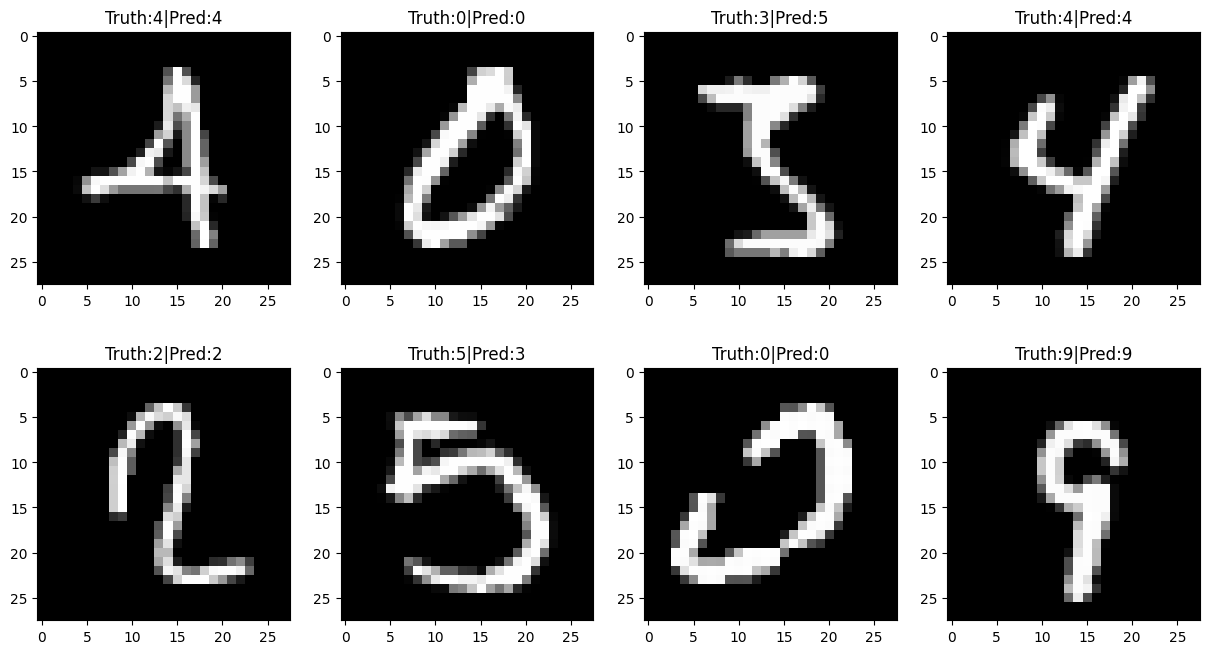

In [119]:
indices=np.random.randint(0,images.shape[0],8).reshape(2,4)
f,ax=plt.subplots(2,4,figsize=(15,8))
for i in range(2):
    for j in range(4):
        idx=indices[i,j]
        y_hat=model(images[idx].reshape(-1,1,28,28))
        pred=torch.argmax(y_hat,dim=1).item()
        truth=int(targets[idx])
        ax[i][j].imshow(images[idx][0].numpy(),cmap='gray')
        ax[i][j].set_title(f'Truth:{truth}|Pred:{pred}')
plt.show()